In [6]:
import matplotlib.pyplot as plt #for plotting
from matplotlib.ticker import EngFormatter #Formater of Engineering notation string
import matplotlib.ticker as mtick  #To draw vertical lines to plots
import numpy as np #numpy
from quantiphy import Quantity as qt#to format numbers 
import mpld3 #interactive plots
#To add the toolbar to plots

## Introduction

* This notebook aims to exercise the block diagram of the OFDM technique for a given number of carriers to be transmitted over a channel;
* Initially, the modulation chosen will be BPSK for each carrier. In the future, QAM will also be applied;
* The application will map and input char word and will codify it into OFDM in terms of ASCII.

## System setup

The block diagram below describes the way one apply OFDM into a communication system:

<img src="OFDM_block_diagram.png" width="400" height="300" />

Source: [NTU Singapore](https://www.csie.ntu.edu.tw/~hsinmu/courses/_media/wn_11fall/ofdm_new.pdf)

### Description

From the input data up to the D/A converter, everything is computed digitally in the transmitter, by using a digital signal processor or a microcontroller unit. Data is formatted into an OFDM symbol through an IFFT algorithm. The process is described as follows. 

The modulator selects the symbols out of a constellation to represent the input data. A Serial to Parallell converter delivers the symbols into an IFFT algorithm, that transforms the amplitudes and phases of the carriers into a time-domain signal. The signal is then formatted with a well-defined pulse (e.g., a raised-cosine pulse) that is bandlimited.


### A note on the D/A Converter

It is worth expanding what happens during the D/A conversion. A zero-order-hold (ZOH) D/A converter may be used to perform the conversion. If one is using a D/A that receives data through SPI communication, this would imply into a making the D/A having a higher sampling frequency that can be supported by the OFDM system.

**This if it is assumed that the D/A's settling time is lower than the SPI's delay time. But this is a topic for another notebook.**

For example, for a 10 bit ZOH D/A converter using SPI to communicate to the MCU responsibile for the OFDM, each symbol would require 10 SPI clock cycles to feed the entire bit word of one single sample of the OFDM signal. 

Thus,

$ T_{s} = 10T_{\mathrm{SPI}}$,

in which $T_{s}$ is the effective sampling frequency seen by the OFDM system. 

In other words, $T_s$ would be the sampling period of a weighted ZOH output signal, such as the one seen below:

<img src="ZOH.png" width="400" height="300" />

In conclusion, each change of the ZOH amplitude signal in red above represents a 10 bit word sent by the SPI bus. And $T_s$ represents the update time of the ZOH (its sampling frequency).


Moreover, for a SPI bus of $1\;\mathrm{\mu s}$ clock period, it would require **10 $\mathrm{\mu s}$ to feed the bitstream corresponding to one digital sample of the OFDM symbol**. For a 32 carriers OFDM, this would imply into a time-domain signal of 32 samples, and a 32 length FFT algorithm. **Meaning, 32 ZOH periods to format one single OFDM pulse.**

Therefore, the OFDM symbol period would be of

$T_{symbol} = 32T_{s} = 32 \times 10\;\mathrm{\mu s} = 320\;\mathrm{\mu s}$

Furthermore, since the effective sampling period of the system is $10\;\mathrm{\mu s}$ (10 SPI periods), Nyquist tells us that the maximum allowable frequency we can reproduce would be $ 1/(2 \times T_s)$, or 500 kHz in our case, with a 10 bit resolution.

Hence, the last reliable carrier of a bandbase OFDM system would be 500 kHz, with the minimum recovery resolution.

## Communication parameters

Based on the arguments provided below, our OFDM scenario is aligned with the following parameters:

* SPI Bus clock of 1 MHz, or 1 $T_{\mathrm{SPI}} = 1\;\mathrm{\mu s}$;

* ZOH resolution of 10 bits, or $2^{10} = 1024$ levels; 

* ZOH Sampling period of $ T_{s} = 10T_{\mathrm{SPI}} = 10\;\mathrm{\mu s}$;

* Symbol period of 32 samples (**32 carriers**) $T_{symbol} = 32 T_s = 320 \;\mathrm{\mu s}$;

* Maximum allowable carrier to be recovered: **500 kHz**;

* Desired modulation scheme of each carrier: **Binary phase shift keying (BPSK)**;

* Maximum number of bits per symbol: **32 bits** (1 bit for each BPSK carrier);

## Modeling the ZOH

* In this section we will show how we model the ZOH to effectivelly reproduce the OFDM signals over the channel.

Interpolation Function: Credits to Jckantor's Github. [Link here](https://jckantor.github.io/CBE30338/08.01-Zero-Order-Hold-and-Interpolation.html)

In [1]:
def interp0(x, xp, yp):
    """Zeroth order hold interpolation w/ same
    (base)   signature  as numpy.interp."""

    def func(x0):
        if x0 <= xp[0]:
            return yp[0]
        if x0 >= xp[-1]:
            return yp[-1]
        k = 0
        while x0 > xp[k]:
            k += 1
        return yp[k-1]
    
    if isinstance(x,float):
        return func(x)
    elif isinstance(x, list):
        return [func(x) for x in x]
    elif isinstance(x, np.ndarray):
        return np.asarray([func(x) for x in x])
    else:
        raise TypeError('argument must be float, list, or ndarray')

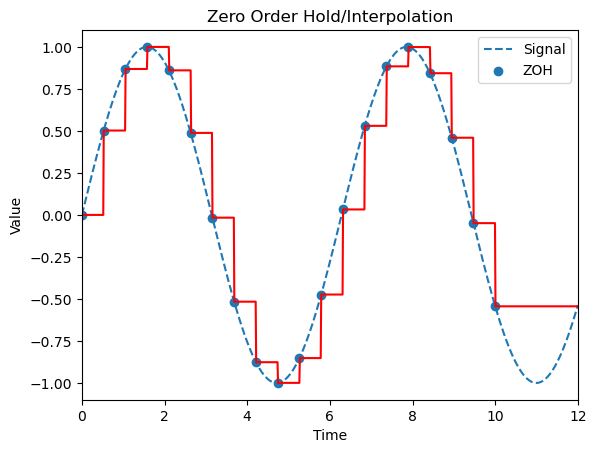

In [4]:
#demonstration

%matplotlib inline

# choose a function
f = np.sin

# sampled signal
xp = np.linspace(0,10,20)
yp = f(xp)

# interpolation grid with 'true' function
x = np.linspace(0,12,1000)
plt.plot(x,f(x),'--')

# plot
plt.scatter(xp,yp)
plt.plot(x,interp0(x,xp,yp),'r')
plt.xlim([x.min(),x.max()])
plt.title('Zero Order Hold/Interpolation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Signal','ZOH'])

Source: [Jckantor's Github](https://jckantor.github.io/CBE30338/08.01-Zero-Order-Hold-and-Interpolation.html)

## Communication Parameters

* The next code will show some data regarding the communication parameters of our system.
* To reason behind several communication parameters, please refer to the following picture:

<img src="nyquist_frequency.png" width="400" height="300" />

Source: [Wikipedia](https://en.wikipedia.org/wiki/Nyquist_frequency)

In [25]:
#Generating a 32 samples carrier of 320 us
#No quantization error employed. Assuming infinite resolution 

R_spi = 1e6 #spi of 1 megabits per second
spi_bits = 10
T_spi = 1/R_spi; #spi clock period
T_s = spi_bits*T_spi #sampling period of zoh
F_s = 1/T_s #sampling frequency

#OFDM parameters
Ncarriers = 32
bits_per_carrier = 1
bits_per_symbol = bits_per_carrier*Ncarriers
T_sym = Ncarriers * T_s #total ofdm symbol period
F_nyquist = F_s/2 #available nyquist frequency

f_carriers = np.linspace(0,F_nyquist,Ncarriers) #list of carriers

print("SPI clock rate:")
print(qt(T_spi,'s'))
print("ZOH sampling period:")
print(qt(T_s,'s'))
print("ZOH sampling frequency:")
print(qt(F_s,'Hz'))
print("OFDM symbol period:")
print(qt(T_sym,'s'))
print("Number of carriers:")
print(Ncarriers)
print("Nyquist frequency:")
print(qt(F_s/2,'Hz'))
print("Bandwidth of each carrier:")
print(qt(F_nyquist/32,'Hz'))
print("Bits per Carrier:")
print(bits_per_symbol)
print("Theoretical Data-rate:")
print(qt(bits_per_symbol/T_sym,'bps'))
print("Carrier frequencies:")
print(f_carriers.tolist())



SPI clock rate:
1 us
ZOH sampling period:
10 us
ZOH sampling frequency:
100 kHz
OFDM symbol period:
320 us
Number of carriers:
32
Nyquist frequency:
50 kHz
Bandwidth of each carrier:
1.5625 kHz
Bits per Carrier:
32
Theoretical Data-rate:
100 kbps
Carrier frequencies:
[0.0, 1612.903225806452, 3225.806451612904, 4838.709677419356, 6451.612903225808, 8064.516129032259, 9677.419354838712, 11290.322580645163, 12903.225806451615, 14516.129032258068, 16129.032258064519, 17741.93548387097, 19354.838709677424, 20967.741935483875, 22580.645161290326, 24193.54838709678, 25806.45161290323, 27419.35483870968, 29032.258064516136, 30645.161290322587, 32258.064516129038, 33870.96774193549, 35483.87096774194, 37096.774193548394, 38709.67741935485, 40322.580645161295, 41935.48387096775, 43548.387096774204, 45161.29032258065, 46774.193548387106, 48387.09677419356, 50000.00000000001]
